In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib as plt
import seaborn as sns

In [2]:
housing = pd.read_csv('Dataset/Melbourne_housing_FULL.csv')

<AxesSubplot: >

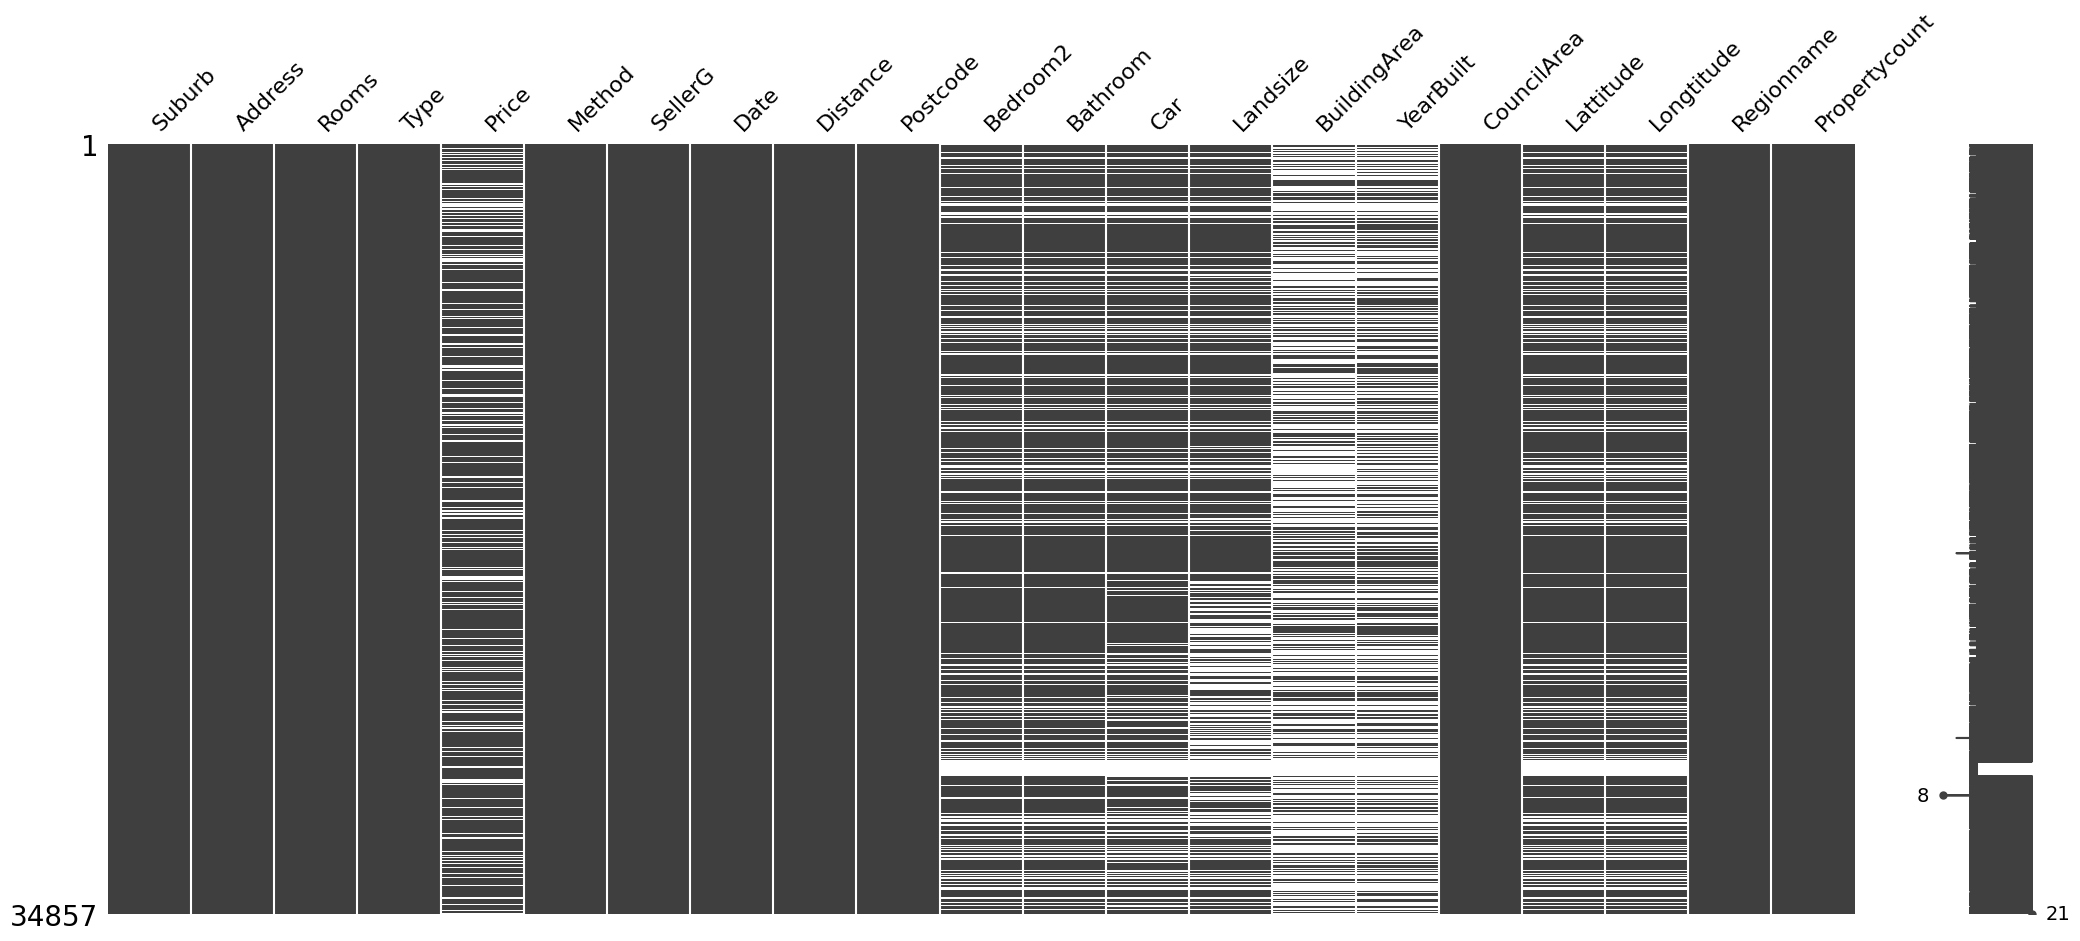

In [3]:
msno.matrix(housing)

<AxesSubplot: >

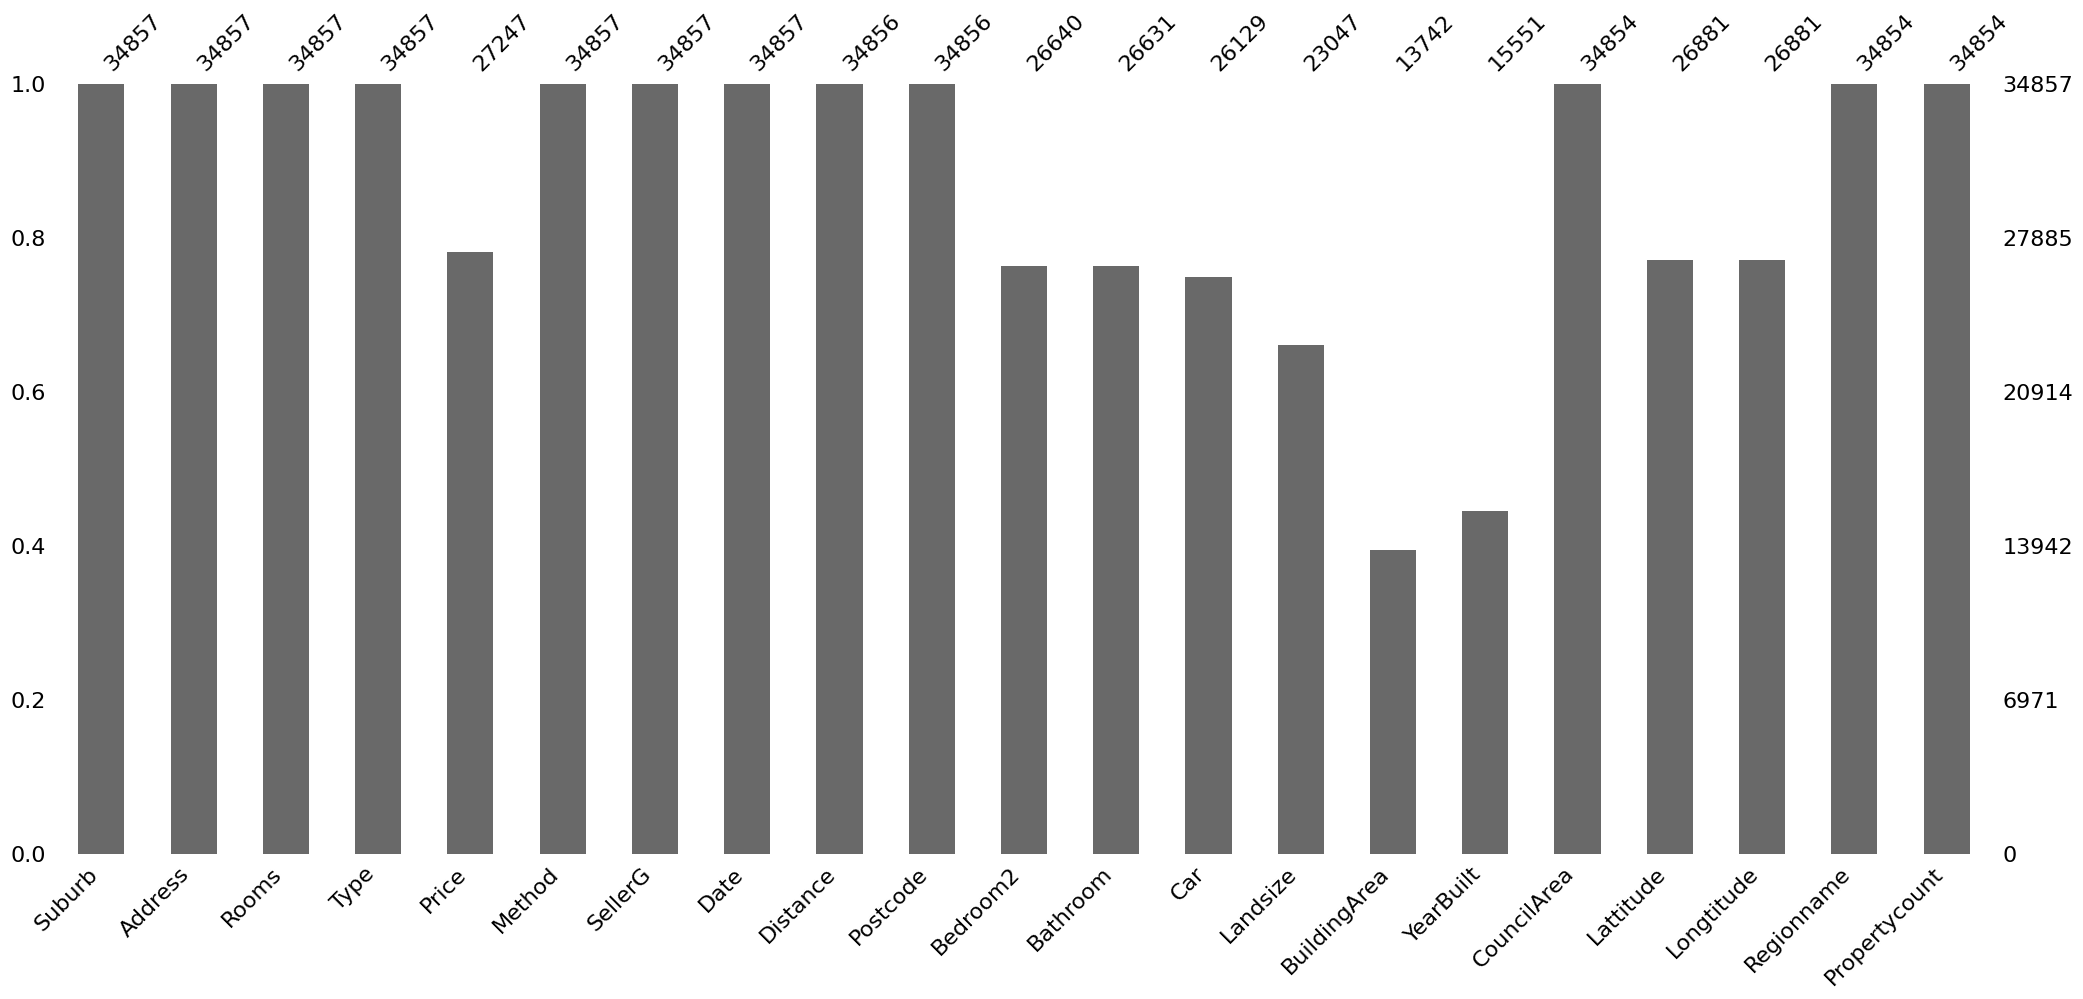

In [4]:
msno.bar(housing)

<AxesSubplot: >

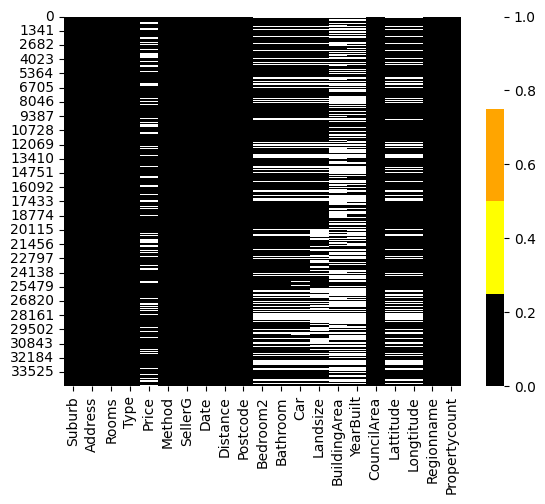

In [5]:
sns.heatmap(data = housing.isnull(),cmap = sns.color_palette(['black','yellow','orange','white']),cbar=True)

C:\Users\004GX3744\AppData\Local\Temp\ipykernel_1940\530249887.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(housing.corr())


<AxesSubplot: >

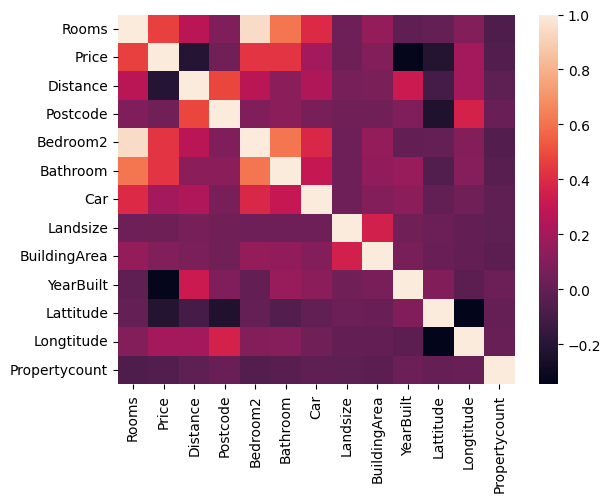

In [7]:
sns.heatmap(housing.corr())

In [5]:
##Target and Predictors
housing_target = housing.Price
housing_predictors = housing.drop(['Price'], axis=1)
#For keeping the example simple, we'll use only numeric predictors 
housing_numeric_predictors = housing_predictors.select_dtypes(exclude=['object'])

In [14]:
#Splitting our data into Train and Test
import numpy as np
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing_numeric_predictors, housing_target, test_size=0.2, random_state=0)
#Detecting Missing Values of train data
train_missing_val = X_train.isnull().sum()
train_missing_percent = X_train.isnull().sum()*100/len(X_train)
train_missing_table = pd.concat([train_missing_val,train_missing_percent],axis=1)
train_missing_summary = train_missing_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
#Detecting Missing Values of test data
test_missing_val = X_test.isnull().sum()
test_missing_percent = X_test.isnull().sum()*100/len(X_test)
test_missing_table = pd.concat([test_missing_val,test_missing_percent],axis=1)
test_missing_summary = test_missing_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})

In [25]:
train_missing_summary

,Missing Values,% of Total Values
Rooms,0,0.000000
Distance,1,0.003586
Postcode,1,0.003586
Bedroom2,6586,23.618433
Bathroom,6593,23.643536
Car,6997,25.092344
Landsize,9459,33.921463
BuildingArea,16909,60.638336
YearBuilt,15444,55.384615
Lattitude,6399,22.947821


#### Create Function to Measure Quality of An Approach
We’ve loaded a function mae_score(X_train, X_test, y_train, y_test) to compare the quality of different approaches to missing values. This function reports the out-of-sample Mean Absolute Error (MAE) score from a Random Forest.

We know that an error basically is the absolute difference between the actual values and the values that are predicted. MAE takes the average of this error from every sample in a dataset.

Random forest is a commonly-used machine learning algorithm trademarked by Leo Breiman and Adele Cutler, which combines the output of multiple decision trees to reach a single result. Its ease of use and flexibility have fueled its adoption, as it handles both classification and regression problems. Let’s move onto some methods!

In [35]:
#Function to measure the quality of an approach
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
def mae_score(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    return mean_absolute_error(y_test, predicts)

## 2. Listwise Deletion

In [80]:
#Reset index of predictors
X_train_reset = X_train.reset_index()
X_test_reset = X_test.reset_index()
#Get the target without missing value in predictors
listwise_y_train_index = X_train_reset.loc[X_train_reset.isnull().sum(1)>0].index
listwise_y_train = y_train.drop(y_train.index[listwise_y_train_index])
listwise_y_test_index = X_test_reset.loc[X_test_reset.isnull().sum(1)>0].index
listwise_y_test = y_test.drop(y_test.index[listwise_y_test_index])
#Drop rows that containing missing values
listwise_X_train = X_train.dropna()
listwise_X_test = X_test.dropna()
listwise_y_train = listwise_y_train.replace(np.nan,listwise_y_train.mean())
listwise_y_test = listwise_y_test.replace(np.nan,listwise_y_test.mean())
#Get a MAE score
print("Mean Absolute Error from Listwise Deletion:")
score_list_wise_deletion = mae_score(listwise_X_train, listwise_X_test, listwise_y_train, listwise_y_test)
print(score_list_wise_deletion)     

Mean Absolute Error from Listwise Deletion:
249916.2889566638


## 3. Dropping entire columns

In [81]:
#Dropping entire columns
cols_with_missing = [col for col in X_train.columns 
                                 if X_train[col].isnull().any()]
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test  = X_test.drop(cols_with_missing, axis=1)
y_train = y_train.replace(np.nan,y_train.mean())
y_test = y_test.replace(np.nan,y_test.mean())
#Get a MAE score
print("Mean Absolute Error from dropping columns with Missing Values:")
score_dropping_column = mae_score(reduced_X_train, reduced_X_test, y_train, y_test)
print(score_dropping_column)

Mean Absolute Error from dropping columns with Missing Values:
342078.6147944174


# IMPUTATIONS

## a. Constant Imputer

In [82]:
from sklearn.impute import SimpleImputer
#Constant Imputer
constant_imputer = SimpleImputer(strategy='constant')
constant_X_train = constant_imputer.fit_transform(X_train)
constant_X_test = constant_imputer.transform(X_test)
print("Mean Absolute Error from Constant Imputation:")
score_constant_imputer = mae_score(constant_X_train, constant_X_test, y_train, y_test)
print(score_constant_imputer)      

Mean Absolute Error from Constant Imputation:
248281.39554222437


## b. Mean Imputer

In [83]:
#Mean Imputer
mean_imputer = SimpleImputer(strategy='mean')
mean_X_train = mean_imputer.fit_transform(X_train)
mean_X_test = mean_imputer.transform(X_test)
print("Mean Absolute Error from Mean Imputation:")
score_mean_imputer = mae_score(mean_X_train, mean_X_test, y_train, y_test)
print(score_mean_imputer)

Mean Absolute Error from Mean Imputation:
245434.223238485


## c. Median Imputer

In [84]:
#Median Imputer
median_imputer = SimpleImputer(strategy='median')
median_X_train = median_imputer.fit_transform(X_train)
median_X_test = median_imputer.transform(X_test)
print("Mean Absolute Error from Median Imputation:")
score_median_imputer = mae_score(median_X_train, median_X_test, y_train, y_test)
print(score_median_imputer)      

Mean Absolute Error from Median Imputation:
244742.57202370005


## d. Mode Imputer

In [88]:
#Mode Imputer
mode_imputer = SimpleImputer(strategy='most_frequent')
mode_X_train = mode_imputer.fit_transform(X_train)
mode_X_test = mode_imputer.transform(X_test)
print("Mean Absolute Error from Mode Imputation:")
score_mode_imputer = mae_score(mode_X_train, mode_X_test, y_train, y_test)
print(score_mode_imputer)

Mean Absolute Error from Mode Imputation:
246761.81915926523


## e. K-Nearest Neighbors (KNN)

In [85]:
##Advanced Imputer
#KNN
from sklearn.impute import KNNImputer
KNN_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
KNN_X_train = KNN_imputer.fit_transform(X_train)
KNN_X_test = KNN_imputer.transform(X_test)
print("Mean Absolute Error from KNN Imputation:")
score_KNN_imputer = mae_score(KNN_X_train, KNN_X_test, y_train, y_test)
print(score_KNN_imputer)

Mean Absolute Error from KNN Imputation:
244511.70863392125


## f. Multivariate Imputation by Chained Equations (MICE)

In [86]:
#MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
mice_imputer = IterativeImputer()
mice_X_train = mice_imputer.fit_transform(X_train)
mice_X_test = mice_imputer.transform(X_test)
print("Mean Absolute Error from MICE Imputation:")
score_MICE_imputer = mae_score(mice_X_train, mice_X_test, y_train, y_test)
print(score_MICE_imputer)      

C:\Users\004GX3744\AppData\Local\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Mean Absolute Error from MICE Imputation:
249207.6695891459


In [96]:
score = [{'score_list_wise_deletion':score_list_wise_deletion,'score_dropping_column':score_dropping_column,
         'score_constant_imputer':score_constant_imputer,'score_mean_imputer':score_mean_imputer,'score_median_imputer':score_median_imputer,
         'score_mode_imputer':score_mode_imputer,'score_KNN_imputer':score_KNN_imputer,'score_MICE_imputer':score_MICE_imputer}]
score_dataframe = pd.DataFrame(score)

In [98]:
score_dataframe

,score_list_wise_deletion,score_dropping_column,score_constant_imputer,score_mean_imputer,score_median_imputer,score_mode_imputer,score_KNN_imputer,score_MICE_imputer
0,249916.288957,342078.614794,248281.395542,245434.223238,244742.572024,246761.819159,244511.708634,249207.669589


In [100]:
score_dataframe.min(axis = 1)

0    244511.708634
dtype: float64